<a href="https://colab.research.google.com/github/huyhuy382003/Apple_stocks_predict/blob/main/EDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
!pip install -q pyspark yfinance pandas matplotlib seaborn
!pip install -q yfinance



In [1]:
from pyspark.sql import SparkSession

# This uses the pyspark that pip installed, no SPARK_HOME needed
spark = SparkSession.builder \
    .master("local[*]") \
    .appName("AAPL_EDA_YF") \
    .getOrCreate()

print("✅ SparkSession started:", spark)


✅ SparkSession started: <pyspark.sql.session.SparkSession object at 0x787572ff2f50>


Schema:
root
 |-- Date: date (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume: double (nullable = true)


First 5 rows:
+----------+------------------+------------------+------------------+------------------+----------+
|Date      |Open              |High              |Low               |Close             |Volume    |
+----------+------------------+------------------+------------------+------------------+----------+
|2012-01-03|12.304186795592656|12.39735451455587 |12.292164843777984|12.359185218811035|3.022208E8|
|2012-01-04|12.322212765113962|12.462867132640715|12.300574063781543|12.425599098205566|2.60022E8 |
|2012-01-05|12.470987187084512|12.579181545225902|12.40246286304358 |12.563553810119629|2.712696E8|
|2012-01-06|12.615844855812668|12.705405964977366|12.599315077810687|12.694887161254883|3.182928E8|
|2012-01-09|12.788059031490675|12.855680503642922|12.66

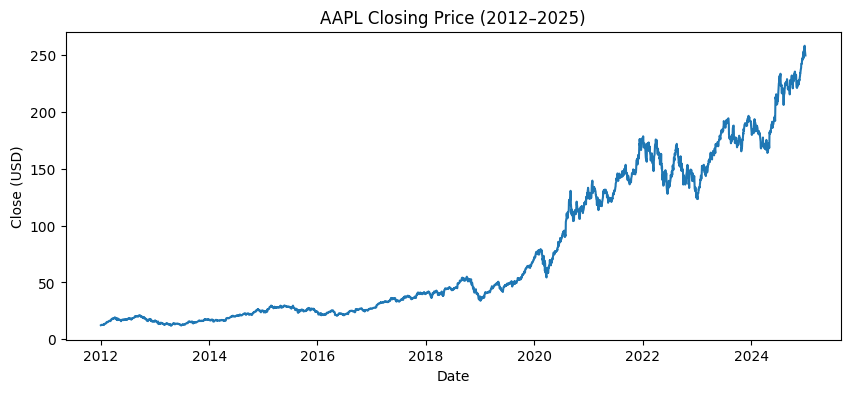

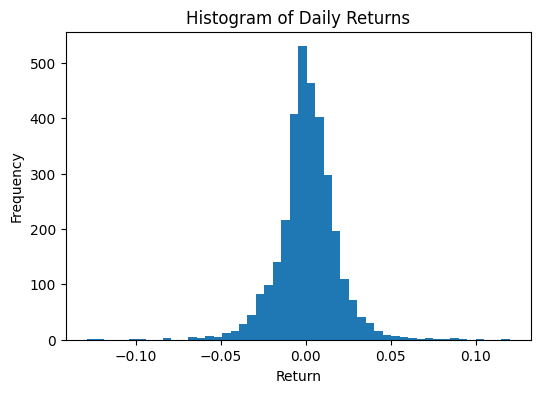

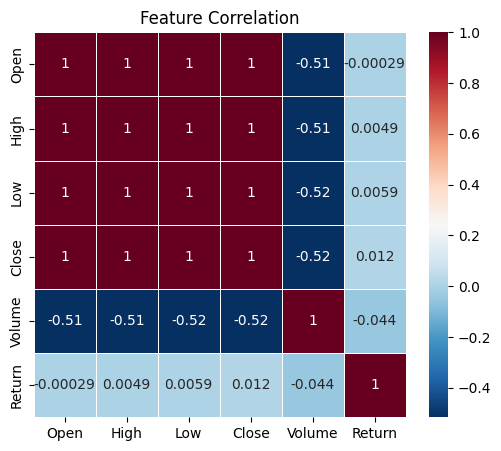

In [5]:
# ── Cell 3: PySpark EDA on AAPL (fixed) ─────────────────────────
import yfinance as yf
import pandas as pd
from pyspark.sql.functions import to_date, col
from pyspark.sql.types import DoubleType

# 1) Download AAPL into pandas
pdf = yf.download("AAPL",
                  start="2012-01-01",
                  end="2025-01-01",
                  progress=False).reset_index()

# 2) Flatten MultiIndex columns if present
if isinstance(pdf.columns, pd.MultiIndex):
    pdf.columns = pdf.columns.get_level_values(0)

# 3) Keep only needed columns
pdf = pdf[["Date", "Open", "High", "Low", "Close", "Volume"]]

# 4) Spark DataFrame + cast types
sdf = spark.createDataFrame(pdf)
for c in ["Open", "High", "Low", "Close", "Volume"]:
    sdf = sdf.withColumn(c, col(c).cast(DoubleType()))
sdf = sdf.withColumn("Date", to_date(col("Date"), "yyyy-MM-dd"))

# ── EDA ───────────────────────────────────────────────────────────
# a) Schema & sample
print("Schema:")
sdf.printSchema()
print("\nFirst 5 rows:")
sdf.show(5, truncate=False)

# b) Summary statistics
desc = sdf.describe().toPandas().set_index("summary").T
print("\nSummary Statistics:")
print(desc)

# c) Convert to pandas for plotting
pdf2 = sdf.orderBy("Date").toPandas()
pdf2["Return"] = pdf2["Close"].pct_change()

import matplotlib.pyplot as plt
import seaborn as sb

# d) Closing price over time
plt.figure(figsize=(10,4))
plt.plot(pdf2["Date"], pdf2["Close"], label="Close")
plt.title("AAPL Closing Price (2012–2025)")
plt.xlabel("Date"); plt.ylabel("Close (USD)")
plt.show()

# e) Histogram of daily returns
plt.figure(figsize=(6,4))
plt.hist(pdf2["Return"].dropna(), bins=50)
plt.title("Histogram of Daily Returns")
plt.xlabel("Return"); plt.ylabel("Frequency")
plt.show()

# f) Correlation heatmap
corr = pdf2[["Open","High","Low","Close","Volume","Return"]].corr()
plt.figure(figsize=(6,5))
sb.heatmap(corr, annot=True, cmap="RdBu_r", linewidths=0.5)
plt.title("Feature Correlation")
plt.show()


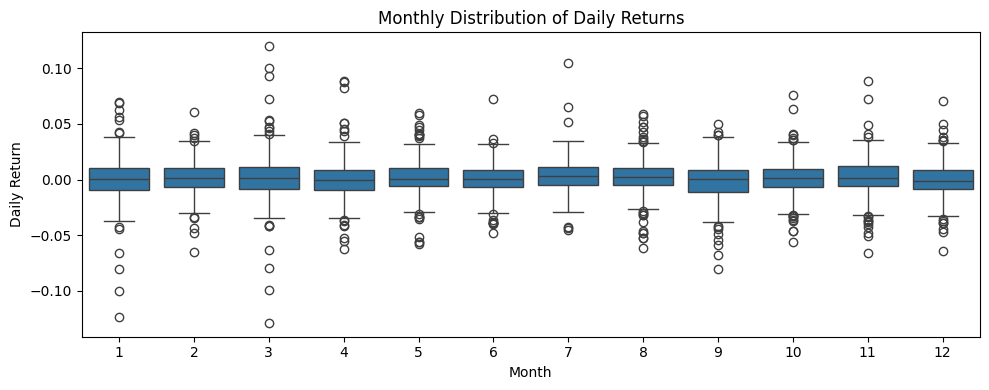

<Figure size 800x400 with 0 Axes>

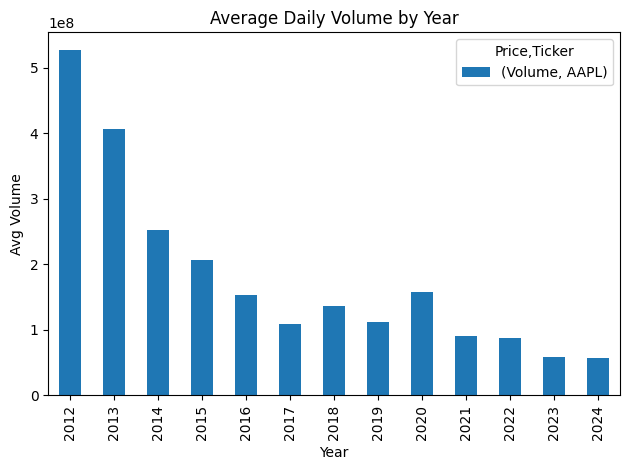

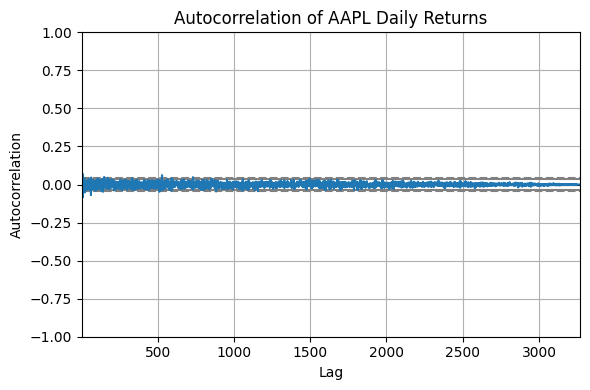

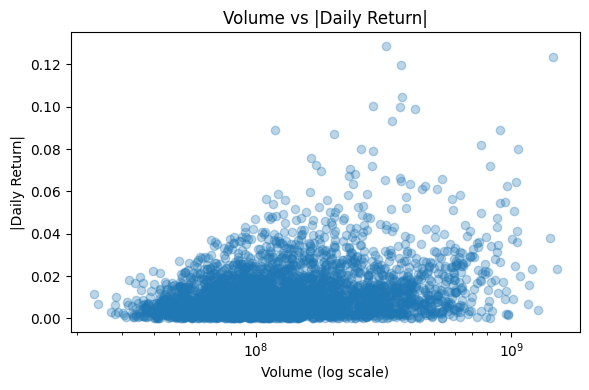

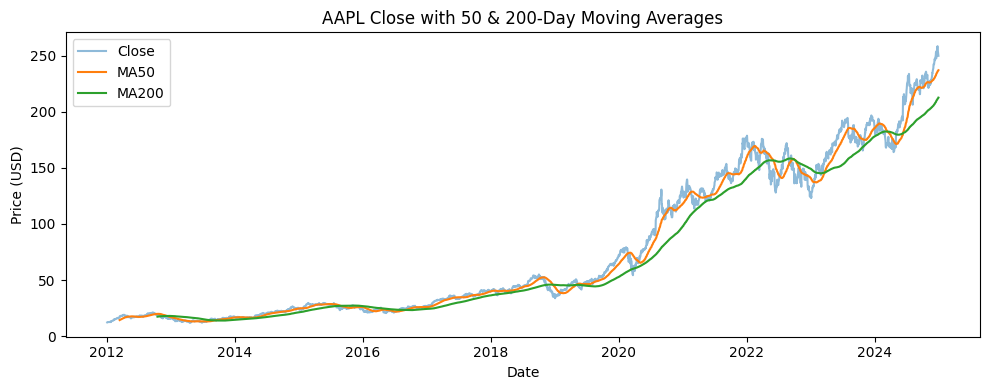

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb

df = yf.download("AAPL",
                 start="2012-01-01",
                 end="2025-01-01",
                 progress=False).reset_index()

# 2) Prepare features
df['Return'] = df['Close'].pct_change()
df['Year']   = df['Date'].dt.year
df['Month']  = df['Date'].dt.month

# A) Boxplot of daily returns by month
plt.figure(figsize=(10,4))
sb.boxplot(x='Month', y='Return', data=df)
plt.title("Monthly Distribution of Daily Returns")
plt.xlabel("Month")
plt.ylabel("Daily Return")
plt.tight_layout()
plt.show()

# B) Average volume by year (bar chart)
vol_year = df.groupby('Year')['Volume'].mean()
plt.figure(figsize=(8,4))
vol_year.plot(kind='bar')
plt.title("Average Daily Volume by Year")
plt.xlabel("Year")
plt.ylabel("Avg Volume")
plt.tight_layout()
plt.show()

# C) Autocorrelation of daily returns
plt.figure(figsize=(6,4))
pd.plotting.autocorrelation_plot(df['Return'].dropna())
plt.title("Autocorrelation of AAPL Daily Returns")
plt.tight_layout()
plt.show()

# D) Scatter: Volume vs Absolute Return
plt.figure(figsize=(6,4))
plt.scatter(df['Volume'], df['Return'].abs(), alpha=0.3)
plt.xscale('log')
plt.title("Volume vs |Daily Return|")
plt.xlabel("Volume (log scale)")
plt.ylabel("|Daily Return|")
plt.tight_layout()
plt.show()

# E) Moving averages crossover
df['MA50']  = df['Close'].rolling(50).mean()
df['MA200'] = df['Close'].rolling(200).mean()
plt.figure(figsize=(10,4))
plt.plot(df['Date'], df['Close'], label='Close', alpha=0.5)
plt.plot(df['Date'], df['MA50'],  label='MA50')
plt.plot(df['Date'], df['MA200'], label='MA200')
plt.title("AAPL Close with 50 & 200-Day Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.tight_layout()
plt.show()
